<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/CSV_to_UVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hier wird mit Hilfe der Messdaten der UVI berechnet

In [1]:
# Import der benötigten Module
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from google.colab import files

In [2]:
# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Monat der importiert werden soll
month = '22.07'

In [4]:
# Import der CSV mit den rohen Messdaten
# Pfad zur CSV-Datei auf Google Drive
drive_path = '/content/drive/My Drive/Colab_Notebooks/CSV_Messdaten/' + month

# CSV-Datei einlesen und DataFrame erstellen
df_Messdaten = pd.read_csv(drive_path)

In [5]:
# df_Messdaten

In [6]:
# Benutzerdefinierte Gewichtungsfunktion
def weight_function(Wellenlaenge):
    if Wellenlaenge <= 298:
        return 1
    elif Wellenlaenge > 298 and Wellenlaenge <= 328:
        return 10**(0.094 * (298.0 - Wellenlaenge))
    elif Wellenlaenge > 328 and Wellenlaenge <= 400:
        return 10**(0.015 * (139.0 - Wellenlaenge))
    else:
        return 0

In [7]:
# Anwenden der Gewichtungsfunktion auf den DataFrame
# Bereich von Spalte x bis Spalte y (einschließlich y)
x = '290.0'
y = '400.0'
selected_columns = df_Messdaten.columns[(df_Messdaten.columns.get_loc(x)):(df_Messdaten.columns.get_loc(y)+1)]

In [8]:
df_Gewichtet = []
df_Gewichtet = df_Messdaten[selected_columns].apply(lambda col: col * weight_function(float(col.name)), axis=0)

In [9]:
def integrate_row(row):
    x_values = np.array([float(col) for col in row.index])  # X-Werte aus Spaltennamen extrahieren
    y_values = np.array(row)
    integral = np.trapz(y_values, x_values)
    return integral

In [10]:
ser_UVI = []
df_UVI = []

ser_UVI = df_Gewichtet.apply(integrate_row, axis=1)
df_UVI = pd.DataFrame(ser_UVI, columns=['erythem'])

In [11]:
type(df_Gewichtet), type(df_UVI)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [12]:
# Exportieren
columns_to_copy = ['Messzeitpunkt', 'Uhrzeit', 'Datum', 'Datetime']

for col in columns_to_copy:
  df_Gewichtet.insert(0, col, df_Messdaten[col])
  df_UVI.insert(0, col, df_Messdaten[col])
  df_UVI['UVI'] = df_UVI['erythem'].copy() * 40

In [13]:
# df_UVI

In [14]:
def save_dataframe_to_drive(dataframe, folder_path, filename):

    # Erstelle den vollen Pfad zur Datei
    full_path = os.path.join(folder_path, filename)

    # Speichere den DataFrame als CSV-Datei auf Google Drive
    dataframe.to_csv(full_path, index=False)

    print(f'Der DataFrame wurde als {filename} in {folder_path} auf Google Drive gespeichert.')

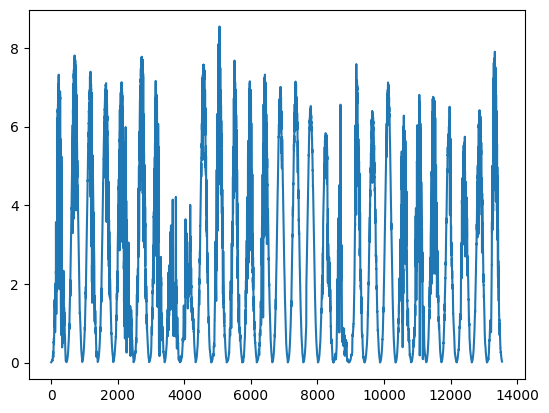

In [15]:
plt.plot(df_UVI['UVI'])

In [16]:
save_dataframe_to_drive(df_UVI, '/content/drive/My Drive/Colab_Notebooks/CSV_UVI', month)

Der DataFrame wurde als 22.07 in /content/drive/My Drive/Colab_Notebooks/CSV_UVI auf Google Drive gespeichert.


In [17]:
# save_dataframe_to_drive(df_Gewichtet, '/content/drive/My Drive/Colab_Notebooks/CSV_Gewichtet', month)